In [4]:
import pandas as pd
import numpy as np
import deap as dp
import random
from deap import base, creator, tools, gp, algorithms
import time
import matplotlib.pyplot as plt
import PyPDF2 as pdf

In [5]:
oferta = pd.read_csv('oferta.csv')
asignaturas = pd.read_csv('asignaturas.csv')
formato_cargas = pd.read_csv('formato_cargas.csv')
plan_2016 = pd.read_csv('2016ID.csv')
seriaciones = pd.read_csv('../seriacion.csv')

In [6]:
planes = {
    '2016ID': plan_2016
}

# Definición de funciones útiles

In [7]:
matriculas = formato_cargas.query('n_matricula > 160000000')['n_matricula'].unique()

## Función para obtener un Kardex aleatorio

In [8]:
def plot_fitness(generation_solution_fitness):
    fig = plt.figure()
    plt.plot(generation_solution_fitness, linewidth=3)
    plt.title('Desempeño por generación')
    plt.xlabel('Generación')
    plt.ylabel('Desempeño')
    plt.show()

In [9]:
def obtenerKardex(mat = -1):
    if(mat == -1):
        mat = np.random.choice(matriculas)
    return formato_cargas.query('n_matricula == ' + str(mat)).sort_values('periodo')

In [10]:
def leerPdfKardex(nombre):
    reader = pdf.PdfReader(open('../kardex/' + nombre + '.pdf','rb'))
    kardex = ''
    for i in range(len(reader.pages)):
        kardex += reader.pages[i].extract_text()
    kardex = kardex.split('\n')
    
    nombre = kardex[3][36:-10].split('/')
    nombre = nombre[1][1:] + ' ' + nombre[0][:-1]
    matricula = int(kardex[3][-9:])
    situacion = kardex[4][:-7]
    plan = kardex[4][-6:]

    claves = []
    periodos = []
    calificaciones = []

    lineas = kardex[4:-7]
    for row in lineas:
        palabras = row.split(' ')
        if len(palabras) >= 6:
            if palabras[0] != 'Plan':
                claves.append(palabras[0])
                for i in range(len(palabras)):
                    if palabras[i][0:2] == '20' and len(palabras[i]) == 6:
                        periodos.append(int(palabras[i]))
                        calificaciones.append(palabras[i+1])

    if len(claves) != len(calificaciones) or len(calificaciones) != len(periodos):
        raise Exception('Error en la lectura del archivo PDF\n' + 'Periodos: ' + str(len(periodos)) + '\nClaves: ' + str(len(claves)) + '\nCalificaciones: ' + str(len(calificaciones)))
                        
    for i in range(len(calificaciones)):
        if(calificaciones[i] == 'S/A'):
            calificaciones[i] = 10
        elif calificaciones[i] == 'N/A':
            calificaciones[i] = 0
        else:
            calificaciones[i] = int(calificaciones[i])    
        
    kardex = pd.DataFrame({
        'clave': claves,
        'periodo': periodos,
        'promediofinal': calificaciones
    })
    kardex = kardex.query('periodo < ' + str(periodoActual))
    
    return nombre,matricula,situacion,plan,kardex

In [11]:
def obtenerCreditos(kardex):
    claves = kardex.query('promediofinal >= 7')['clave'].unique()
    totalCreditos = 0
    for clave in claves:
        if(clave[0:2] == 'LI' or clave[0:2] == 'TA' or clave[0:2] == 'AD'):
            continue
        totalCreditos += plan.query('clave == "' + clave + '"')['creditos'].values[0]
    return totalCreditos

In [12]:
def obtenerRecomendacionesUnicas(recomendaciones,umbral):
    recomendacionesFinal = []
    for rec in recomendaciones:
        recomendacionesFinal.append(list(set(rec)))
    recomendacionesFinal = list(np.unique(recomendacionesFinal))
    recomendacionesFinal.sort(key=lambda x: -obtenerDesempenoPonderado(x))

    return recomendacionesFinal

In [13]:
def ordenarRecomendacionesPor(recomendaciones,objetivo):
    if objetivo == 'upcc':
        recomendaciones.sort(key=lambda x: -UpCC(x))
    elif objetivo == 'upmr':
        recomendaciones.sort(key=lambda x: -UpMR(x))
    elif objetivo == 'upcm':
        recomendaciones.sort(key=lambda x: -UpCM(x))
    elif objetivo == 'cpdh':
        recomendaciones.sort(key=lambda x: CpDH(x))
    elif objetivo == 'cpah':
        recomendaciones.sort(key=lambda x: CpAH(x))
    elif objetivo == 'despon':
        recomendaciones.sort(key=lambda x: -obtenerDesempenoPonderado(x))
    else:
        raise Exception('Objetivo solo puede ser: upcc, upmr, upcm, cpdh, cpah y despon')

In [14]:
def verKardex():
    print('Matricula: ' + str(kardex.iloc[0]['n_matricula']))
    print('Carrera: ' + str(kardex.iloc[0]['carrera']))
    print('Creditos: ' + str(obtenerCreditos(kardex))) 
    print('Materias Reprobadas:')
    for clave in obtenerMateriasReprobadas(kardex):
        if(clave[0:2] == 'LI' or clave[0:2] == 'TA' or clave[0:2] == 'AD'):
            continue
        print('\t' + clave,plan.query('clave == "' + clave + '"')['nombre'].values[0])
    print('\n')
    periodos = kardex['periodo'].unique()
    for per in periodos:
        print('Periodo: ' + str(per))
        print('Clave\t\tPromedio\tNombre de asignatura')
        materias = kardex.query('periodo == ' + str(per))
        for i in range(len(materias)):
            if(materias.iloc[i]['promediofinal'] < 7):
                print('* ' + materias.iloc[i]['clave'] + '\t' + str(materias.iloc[i]['promediofinal']) + '\t\t' + materias.iloc[i]['asignatura'])
            else:
                print(materias.iloc[i]['clave'] + '\t\t' + str(materias.iloc[i]['promediofinal']) + '\t\t' + materias.iloc[i]['asignatura'])
        print('\n')
    

## Obtención de oferta útil

In [15]:
def materiaHaSidoAprobada(kardex,clave):
    if len(kardex.query('clave == "' + clave + '" and promediofinal >= 7')) == 0:
        return False
    else:
        return True

In [16]:
def respetaSeriacion(clave,kardex):
    if len(seriaciones.query('ser2 == "' + clave + '"')) == 0:
        return True
    else:
        #Se guarda en necesarias la lista de asignaturas necesarias para llevar la asignura "clave"
        necesarias = seriaciones.query('ser2 == "' + clave + '"')['ser1'].unique()
        
        #Se recorre la lista para comprobar si el estudiante ya pasó las asignaturas necesarias, en caso de que le falte 
        #al menos una, entonces no se respeta la seriación.
        for necesaria in necesarias:
            if not(materiaHaSidoAprobada(kardex,necesaria)):
                return False
        return True

In [276]:
#Filtra las materias que no cumplen las restricciones 1 y 2

def obtenerOfertaUtil(kardex,oferta):
    dias = ['Lunes','Martes','Miercoles','Jueves','Viernes']
    
    #Se eliminan las materias en la oferta que ya han sido aprobadas
    aprobadas = kardex.query('promediofinal >= 7')['clave'].unique()
    for clave in aprobadas:
        oferta = oferta.query('clave != "' + clave + '"')
        
    #Se eliminan las materias que el alumno no puede llevar por la seriación
    ofertaUtilIndex = set(oferta.index.values)
    for idx in oferta.index:
        if not(respetaSeriacion(oferta.loc[idx]['clave'],kardex)):
            ofertaUtilIndex.remove(idx)
            
    #Se eliminan prácticas profesionales y proyecto terminal
    for i in range(len(oferta['clave'].values)):
        clave = oferta['clave'].values[i]
        if clave[0:3] == 'PID' or clave == 'IT0427':
            try:
                ofertaUtilIndex.remove(oferta.index.values[i])
            except:
                continue
    ofertaUtil = oferta.loc[list(ofertaUtilIndex)]
    
    ofertaUtil = pd.merge(ofertaUtil,plan,how='left',on='clave')[['clave','ciclos','Nombre','Maestro','Lunes','Martes','Miercoles','Jueves','Viernes','tipo']]
    
    #Se eliminan materias de elección libre de primer y segundo ciclo
    if(materiaHaSidoAprobada(kardex,'IL0102')):
        ofertaUtil = ofertaUtil.query('clave != "ID0160"')
    if(materiaHaSidoAprobada(kardex,'ID0160')):
        ofertaUtil = ofertaUtil.query('clave != "IL0102"')
    
    if(materiaHaSidoAprobada(kardex,'IT0103')):
        ofertaUtil = ofertaUtil.query('clave != "ID0161"')
    if(materiaHaSidoAprobada(kardex,'ID0161')):
        ofertaUtil = ofertaUtil.query('clave != "IT0103"')
        
    if(materiaHaSidoAprobada(kardex,'ID0264')):
        ofertaUtil = ofertaUtil.query('clave != "ID0262"')
    if(materiaHaSidoAprobada(kardex,'ID0262')):
        ofertaUtil = ofertaUtil.query('clave != "ID0264"')
        
    if(materiaHaSidoAprobada(kardex,'ID0263')):
        ofertaUtil = ofertaUtil.query('clave != "ID0265"')
    if(materiaHaSidoAprobada(kardex,'ID0265')):
        ofertaUtil = ofertaUtil.query('clave != "ID0263"')
        
    #Si la disponibilidad de horario es una restricción, entonces elimina las materias que violen la restricción
    if(disponibilidadComoRestriccion):
        indices = set(ofertaUtil.index)
        indicesUtiles = indices.copy()
        for dia in dias:
            for i in indices:
                if ofertaUtil.loc[i][dia] == '-':
                    continue
                
                horaInicio = int(ofertaUtil.loc[i][dia][0:2])
                horaFin = int(ofertaUtil.loc[i][dia][6:8])
                
                for hora in range(horaInicio,horaFin):
                    if not(disponibilidad.query('hora == ' + str(hora))[dia].values[0]):
                        if i in indicesUtiles:
                            indicesUtiles.remove(i)
        indicesUtiles = list(indicesUtiles)
        ofertaUtil = ofertaUtil.loc[indicesUtiles]
    
    return ofertaUtil

## Generación de carga aleatoria válida

En esta sección creamos las funciones "generarCargaValida" la cual retorna una string de bits representando una carga académica con base a la oferta útil. También se crea la función "obtenerDatosCarga" que nos ayuda a obtener los datos de una carga académica con base a la oferta útil y a una string de bits que denominamos "bits de carga"

In [18]:
def generarSolucionAleatoria(ofertaUtil):
    solucion = [-1] * 9
    for i in range(9):
        gen = np.random.randint(-1,len(ofertaUtil))
        if gen == -1:
            solucion[i] = -1
        else:
            solucion[i] = ofertaUtil.index[gen]
    return solucion

In [19]:
def obtenerDatosCarga(solucion):
    solucionU = np.array(solucion)
    solucionU = np.unique(solucionU)
    solucionU = solucionU[solucionU >= 0]
    
    return ofertaUtil.loc[solucionU]

In [20]:
def comprobarTraslapacion(solucion,ofertaUtil):
    datosCarga = obtenerDatosCarga(solucion)
    dias = ['Lunes','Martes','Miercoles','Jueves','Viernes']
    
    for dia in dias:
        horarioDia = datosCarga.sort_values(dia)[dia].values
        for i in range(len(horarioDia)):
            if horarioDia[i] == '-':
                continue
            horaInicioI = int(horarioDia[i][0:2])
            horaFinI = int(horarioDia[i][6:8])
            
            for j in range(i+1,len(horarioDia)):
                horaInicioJ = int(horarioDia[j][0:2])
                horaFinJ = int(horarioDia[j][6:8])
                
                if not(horaFinJ  <= horaInicioI or horaInicioJ >= horaFinI):
                    return True
    return False

In [21]:
def esValido(solucion,ofertaUtil):
    #Si se repite una materia es inválido
    datosCarga = obtenerDatosCarga(solucion)
    if len(datosCarga['clave'].unique()) < len(datosCarga):
        return False
    #Si se traslapan dos materias es inválido
    if comprobarTraslapacion(solucion,ofertaUtil):
        return False
    #Si son menos de 3 materias es inválido
    solucionSet = set(solucion)
    if -1 in solucionSet:
        solucionSet.remove(-1)
    if(len(solucionSet)<3):
        return False
    
    #Si se llevan dos materias de elección libre del ciclo 1 y 2
    clavesSet = set(datosCarga['clave'])
    
    if 'IL0102' in clavesSet and 'ID0160' in clavesSet:
        return False
    if 'IT0103' in clavesSet and 'ID0161' in clavesSet:
        return False
    if 'ID0264' in clavesSet and 'ID0262' in clavesSet:
        return False
    if 'ID0263' in clavesSet and 'ID0265' in clavesSet:
        return False
    
    return True

In [22]:
def generarSolucionValida(ofertaUtil):
    bitsDeCarga = generarSolucionAleatoria(ofertaUtil)
    
    while not(esValido(bitsDeCarga,ofertaUtil)):
        bitsDeCarga = generarSolucionAleatoria(ofertaUtil)
    
    return bitsDeCarga

In [23]:
def obtenerHorario(carga):
    primeraHoraMinima = 24
    ultimaHoraMaxima = 0
    datosCarga = obtenerDatosCarga(carga)
    horario = pd.DataFrame({
        'Hora': ['7:00-8:00','8:00-9:00','9:00-10:00','10:00-11:00','11:00-12:00','12:00-13:00','13:00-14:00','14:00-15:00','15:00-16:00','16:00-17:00','17:00-18:00','18:00-19:00','19:00-20:00','20:00-21:00','21:00-22:00'],
        'Lunes': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
        'Martes': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
        'Miercoles': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
        'Jueves': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
        'Viernes': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
    })
    dias = ['Lunes','Martes','Miercoles','Jueves','Viernes']
    for dia in dias:
        for i in range(len(datosCarga)):
            if datosCarga[dia].iloc[i] == '-':
                continue

            horaInicio = int(datosCarga.iloc[i][dia][0:2])
            horaFin = int(datosCarga.iloc[i][dia][6:8])
            
            primeraHoraMinima = min(primeraHoraMinima,horaInicio)
            ultimaHoraMaxima = max(ultimaHoraMaxima,horaFin)
            
            nombre = datosCarga.iloc[i]['Nombre']

            for hora in range(horaInicio,horaFin):
                horario.loc[hora-7,dia]=nombre
    return horario[(primeraHoraMinima-7):(ultimaHoraMaxima-6)]

# Definición de funciones de utilidad y de costo

## Utilidad de carga académica con base en cantidad ideal de materias

In [24]:
def UpCM(solucion):
    if(cantidadMateriasIdeal == 0):
        return 1
    
    diferenciaMaxima = max(cantidadMateriasIdeal-3,9-cantidadMateriasIdeal)
    solucionSet = set(solucion)
    
    if -1 in solucionSet:
        solucionSet.remove(-1)
        
    tamanoCarga = len(solucionSet)
    separacion = abs(tamanoCarga-cantidadMateriasIdeal)
    
    return 1 - (separacion / diferenciaMaxima)

## Utilidad de carga académica con base en las materias reprobadas

In [25]:
def obtenerMateriasReprobadas(kardex):
    materiasReprobadas = kardex.query('promediofinal < 7')['clave'].unique()
    materiasReprobadasFinal = []
    for clave in materiasReprobadas:
        aprobado = len(kardex.query('clave == "' + clave + '" and promediofinal >= 7'))
        if aprobado == 0 and clave[0:2] != 'LI':
            materiasReprobadasFinal.append(clave)
    return materiasReprobadasFinal

In [26]:
def UpMR(solucion):
    materiasReprobadas = obtenerMateriasReprobadas(kardex)
    materiasReprobadasOfertadas = 0
    if len(materiasReprobadas) == 0:
        return 1
    datosCarga = obtenerDatosCarga(solucion)
    materiasReprobadasCargadas = 0
    
    for clave in materiasReprobadas:
        cargado = len(datosCarga.query('clave == "' + clave + '"'))
        ofertado = len(ofertaUtil.query('clave == "' + clave + '"'))
        if cargado >= 1:
            materiasReprobadasCargadas += 1
        if ofertado >= 1:
            materiasReprobadasOfertadas += 1
        
    if materiasReprobadasOfertadas == 0:
        return 1
    
    #Normalización
    utilidad = (materiasReprobadasCargadas)/(materiasReprobadasOfertadas)
    return utilidad

## Utilidad de carga académica con base en el cierre de ciclos

In [27]:
def UpCC(solucion):
    base = 3
    utilidad = [base**3,base**2,base,1]
    utilidadTotal = 0
    
    menorCiclo = min(ofertaUtil['ciclos']) - 1
    
    datosCarga = obtenerDatosCarga(solucion)
    
    claves = datosCarga['clave'].unique()
    for i in range(len(claves)):
        if claves[i][0:2] == 'AD'or claves[i][0:2] == 'TA' or claves[i][0:2] == 'LI' or claves[i][0:2] == 'PI':
            continue
            
        ciclo = int(plan.query('clave == "' + claves[i] + '"')['ciclos']) - 1
        utilidadTotal += utilidad[ciclo - menorCiclo]
    
    utilidadMaxima = 0
    cantidadMateriasCiclo1 = len(ofertaUtil.query('ciclos == ' + str(menorCiclo+1))['clave'].unique())
    cantidadMateriasCiclo2 = len(ofertaUtil.query('ciclos == ' + str(menorCiclo+2))['clave'].unique())
    cantidadMateriasCiclo3 = len(ofertaUtil.query('ciclos == ' + str(menorCiclo+3))['clave'].unique())
    cantidadMateriasCiclo4 = len(ofertaUtil.query('ciclos == ' + str(menorCiclo+4))['clave'].unique())
    cantidadMateriasMaxima = 9
    
    m1 = m2 = m3 = m4 = 0
    
    if (cantidadMateriasMaxima - cantidadMateriasCiclo1) >= 0:
        m1 = cantidadMateriasCiclo1
        cantidadMateriasMaxima -= cantidadMateriasCiclo1
    else:
        m1 = 9
        cantidadMateriasMaxima = 0
    if (cantidadMateriasMaxima - cantidadMateriasCiclo2) >= 0:
        m2 = cantidadMateriasCiclo2
        cantidadMateriasMaxima -= cantidadMateriasCiclo2
    elif cantidadMateriasMaxima > 0:
        m2 = cantidadMateriasMaxima
        cantidadMateriasMaxima = 0
    if (cantidadMateriasMaxima - cantidadMateriasCiclo3) >= 0:
        m3 = cantidadMateriasCiclo3
        cantidadMateriasMaxima -= cantidadMateriasCiclo3
    elif cantidadMateriasMaxima > 0:
        m3 = cantidadMateriasMaxima
        cantidadMateriasMaxima = 0
    if (cantidadMateriasMaxima - cantidadMateriasCiclo4) >= 0:
        m4 = cantidadMateriasCiclo4
        cantidadMateriasMaxima -= cantidadMateriasCiclo4
    elif cantidadMateriasMaxima > 0:
        m4 = cantidadMateriasMaxima
        cantidadMateriasMaxima = 0
        
    
    utilidadMaxima = m1*utilidad[0] + m2*utilidad[1] + m3*utilidad[2] + m4*utilidad[3]
 
    #Normalización
    utilidadNorm = (utilidadTotal)/(utilidadMaxima)
    return utilidadNorm

## Costo por amplitud de horario

In [28]:
def CpAH(solucion):
    amplitudAceptable = 7
    
    datosCarga = obtenerDatosCarga(solucion)
    dias = ['Lunes','Martes','Miercoles','Jueves','Viernes']
    horaMin = 21
    horaMax = 7
    
    for dia in dias:
        for hora in datosCarga[dia]:
            if hora == '-':
                continue
            horaMin = min(int(hora[0:2]),horaMin)
            horaMax = max(int(hora[6:8]),horaMax)
            
    amplitud = (horaMax - horaMin)
    if amplitud <= amplitudAceptable:
        return 0
    amplitud -= amplitudAceptable
    
    return amplitud / (15 - amplitudAceptable)

## Costo de carga académica con base en las horas libres

#### NOTA: Tomar en cuenta las horas libres por día

In [29]:
def CpHL(solucion,ofertaUtil):
    dias = ['Lunes','Martes','Miercoles','Jueves','Viernes']
    costoTotal = 0
    hlMax = 0

    datosCarga = obtenerDatosCarga(solucion)

    for dia in dias:
        datosCarga = datosCarga.sort_values(dia)
        if datosCarga[dia].iloc[len(datosCarga)-2] == '-':
            continue

        ultimaHoraFin = 0
        for i in range(len(datosCarga)):
            if datosCarga.iloc[i][dia] == '-':
                continue
            if ultimaHoraFin == 0:
                ultimaHoraFin = int(datosCarga.iloc[i][dia][6:8])
                primeraHoraDia = int(datosCarga.iloc[i][dia][0:2])
                continue
            horaInicio = int(datosCarga.iloc[i][dia][0:2])
            costoTotal += (horaInicio - ultimaHoraFin)
            ultimaHoraFin = int(datosCarga.iloc[i][dia][6:8])
        hlMax += (ultimaHoraFin - primeraHoraDia - 2)

    if hlMax == 0:
        return 0
    #Normalización
    costo = (costoTotal)/(hlMax)
    return costo

## Costo de carga académica con base en la disponibilidad de horario del estudiante

Creamos 4 casos diferentes donde los estudiantes trabajan. Guardamos el horario de ocupación de los estudiantes en un dataframe por cada estudiante.

In [30]:
# El estudiante trabaja por las mañanas tiempo completo
disp_est_1 = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Martes": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Miercoles": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Jueves": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Viernes": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
})


# El estudiante trabaja por las tardes tiempo completo
disp_est_2 = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
    "Martes": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
    "Miercoles": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
    "Jueves": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
    "Viernes": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
})

# El estudiante trabaja por las mañanas medio tiempo
disp_est_3 = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False],
    "Martes": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False],
    "Miercoles": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False],
    "Jueves": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False],
    "Viernes": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False],
})
# El estudiante trabaja por las tardes medio tiempo
disp_est_4 = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True],
    "Martes": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True],
    "Miercoles": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True],
    "Jueves": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True],
    "Viernes": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True],
})
disp_est_5 = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],
    "Martes": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],
    "Miercoles": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],
    "Jueves": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],
    "Viernes": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],
})

In [31]:
disponibilidadArr = [disp_est_1,disp_est_2,disp_est_3,disp_est_4,disp_est_5]

In [32]:
def CpDH(solucion):
    disponibilidadTotal = sum(disponibilidad['Lunes']) + sum(disponibilidad['Martes']) + sum(disponibilidad['Miercoles']) + sum(disponibilidad['Jueves']) + sum(disponibilidad['Viernes'])
    if disponibilidadTotal == 75:
        return 0
    
    dias = ['Lunes','Martes','Miercoles','Jueves','Viernes']
    datosCarga = obtenerDatosCarga(solucion)
    costoTotal = 0

    for dia in dias:
        for i in range(len(datosCarga)):
            if datosCarga[dia].iloc[i] == '-':
                continue

            horaInicio = int(datosCarga.iloc[i][dia][0:2])
            horaFin = int(datosCarga.iloc[i][dia][6:8])

            for hora in range(horaInicio,horaFin):
                if not(disponibilidad.query('hora == ' + str(hora))[dia].values[0]):
                    costoTotal += 1
                    
    #Normalización
    costo = (costoTotal)/(75 - disponibilidadTotal)
    return costo

# Definición de la función de desempeño

In [33]:
def obtenerDesempenoPonderado(solucion):
    if not(esValido(solucion,ofertaUtil)):
        return 0
    
    upcc = UpCC(solucion)
    upmr = UpMR(solucion)
    upcm = UpCM(solucion)
    cpdh = CpDH(solucion)
    cpah = CpAH(solucion)
    
    utilidades = {
        "upcc": (upcc * pesos["upcc"]),
        "upmr": (upmr * pesos["upmr"]),
        "upcm": (upcm * pesos["upcm"]),
        "cpdh": pesos["cpdh"] - (cpdh * pesos["cpdh"]),
        "cpah": pesos["cpah"] - (cpah * pesos["cpah"]),
    }
    
    return sum(utilidades.values())

In [34]:
def obtenerDesempeno(solucion):
    if not(esValido(solucion,ofertaUtil)):
        return 0,0,0,1,1
    
    upcc = UpCC(solucion)
    upmr = UpMR(solucion)
    upcm = UpCM(solucion)
    cpdh = CpDH(solucion)
    cpah = CpAH(solucion)
    
    return upcc,upmr,upcm,cpdh,cpah,

In [35]:
def evaluarSolucion(solucion):
    desempeno = obtenerDesempeno(solucion)
    if(desempeno == 0):
        print('Solución no válida')
        return
    
    upcc = UpCC(solucion)
    upmr = UpMR(solucion)
    upcm = UpCM(solucion)
    cpdh = CpDH(solucion)
    cpah = CpAH(solucion)
    
    print("La carga evaluada tiene:")
    print("\t" + str(round(100*upcc,2)) + "% de utilidad por las materias de primeros ciclos llevadas.")
    print("\t" + str(round(100*upmr,2)) + "% del total de las materias reprobadas del estudiante.") 
    print("\t" + str(round(100*upcm,2)) + "% de utilidad por cantidad ideal de materias del estudiante.") 
    print("\t" + str(round(100*cpdh,2)) + "% de costo por sobreposición con las horas donde el estudiante no está disponible.")
    print("\t" + str(round(100*cpah,2)) + "% de costo por el total de amplitud de horario.")

In [36]:
def on_generation(ga_instance):
    print("Generación: " + str(ga_instance.generations_completed))

In [37]:
def obtenerClase():
    gen = np.random.randint(-1,len(ofertaUtil))
    clase = -1 if gen == -1 else ofertaUtil.index[gen]
    return clase

In [38]:
def mutacionUniforme(solucion,prob):
    solucion = solucion.copy()
    for i in range(len(solucion)):
        if random.random() < prob:
            solucion[i] = toolbox.attr_int()
    return dp.creator.Individual(solucion),

In [39]:
def factorial(p):
    res = 1
    
    while p > 0:
        res *= p
        p -= 1
    
    return res

# DEAP

In [40]:
pesos = {
    "upcc": 2,    #Utilidad por cerrar ciclos
    "upmr": 1,    #Utilidad por materias reprobadas
    "upcm": 1,    #Utilidad por cantidad ideal de materias
    "cpdh": 2.5,  #Costo por disponibilidad de horario
    "cpah": 1.5,  #Costo por amplitud de horario
    "cphl": 1     #Costo por horas libres (no se está utilizando actualmente)
}

In [41]:
#creator.create("FitnessMin", base.Fitness, weights=(pesos['upcc'],pesos['upmr'],pesos['upcm'],-pesos['cpdh'],-pesos['cpah']))
creator.create("FitnessMin", base.Fitness, weights=(1,1,1,-1,-1))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [42]:
toolbox = base.Toolbox()
toolbox.register("attr_int", obtenerClase)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_int, n=9)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", obtenerDesempeno)
toolbox.register("mate", tools.cxUniform,indpb=0.5)
toolbox.register("mutate", mutacionUniforme,prob=0.15)

In [43]:
def main(seed=None):
    random.seed(seed)

    # Inicialización de estadísticas
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"

    pop = toolbox.population(n=MU)

    # Evaluación inicial
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Registro de estadísticas
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print('Gen: 0')

    # Inicio del proceso generacional
    for gen in range(1, NGEN):
        #Creación de descendencia
        offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)

        #Evaluación
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        #Selección
        pop = toolbox.select(pop + offspring, MU)

        #Estadísticas
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print('Gen: ' + str(gen))

    return pop, logbook

# Pruebas

In [44]:
valeria = 'GUZMAN ALMEIDA VALERIA DEL CARMEN'
angel = 'LÓPEZ ALVAREZ ANGEL DANIEL'
manuel = 'GUTIERREZ LOPEZ MANUEL ANTONIO'
brandon = '170300103'
darwin = '180300330'
gilberto = '180300331'
rogelio = '180300332'
miguel = '180300338'
alan = '190300384'
dylan = '190300410'
rodrigo = '190300432'
karina = '190300607'

periodoActual = 202301

In [45]:
def saveToCsv(pop,log,estudiante):
    f = open('./logs/' + estudiante + '.csv','w')
    f.write('gen,evals,avg_upcc,avg_upmr,avg_upcm,avg_cpdh,avg_cpah,std_upcc,std_upmr,std_upcm,std_cpdh,std_cpah,min_upcc,min_upmr,min_upcm,min_cpdh,min_cpah,max_upcc,max_upmr,max_upcm,max_cpdh,max_cpah\n')

    for l in log:
        f.write(str(l['gen']) + ',')
        f.write(str(l['evals']) + ',')

        f.write(str(l['avg'][0]) + ',')
        f.write(str(l['avg'][1]) + ',')
        f.write(str(l['avg'][2]) + ',')
        f.write(str(l['avg'][3]) + ',')
        f.write(str(l['avg'][4]) + ',')

        f.write(str(l['std'][0]) + ',')
        f.write(str(l['std'][1]) + ',')
        f.write(str(l['std'][2]) + ',')
        f.write(str(l['std'][3]) + ',')
        f.write(str(l['std'][4]) + ',')

        f.write(str(l['min'][0]) + ',')
        f.write(str(l['min'][1]) + ',')
        f.write(str(l['min'][2]) + ',')
        f.write(str(l['min'][3]) + ',')
        f.write(str(l['min'][4]) + ',')

        f.write(str(l['max'][0]) + ',')
        f.write(str(l['max'][1]) + ',')
        f.write(str(l['max'][2]) + ',')
        f.write(str(l['max'][3]) + ',')
        f.write(str(l['max'][4]) + '\n')

    f.close()

    f = open('./recs/' + estudiante + '.csv','w')
    f.write('a1,a2,a3,a4,a5,a6,a7,a8,a9\n')
    for p in pop:
        f.write(str(p[0]) + ',')
        f.write(str(p[1]) + ',')
        f.write(str(p[2]) + ',')
        f.write(str(p[3]) + ',')
        f.write(str(p[4]) + ',')
        f.write(str(p[5]) + ',')
        f.write(str(p[6]) + ',')
        f.write(str(p[7]) + ',')
        f.write(str(p[8]) + '\n')

    f.close()

## Valeria

In [53]:
estudiante = valeria

In [54]:
disponibilidadComoRestriccion = False
disponibilidad = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [True,True,True,True,True,True,True,True,False,False,False,False,False,False,False],
    "Martes": [True,True,True,True,True,True,True,True,False,False,False,False,False,False,False],
    "Miercoles": [True,True,True,True,True,True,True,True,False,False,False,False,False,False,False],
    "Jueves": [True,True,True,True,True,True,True,True,False,False,False,False,False,False,False],
    "Viernes": [True,True,True,True,True,True,True,True,False,False,False,False,False,False,False]
})
plan = plan_2016

nombre,matricula,situacion,planN,kardex = leerPdfKardex(estudiante)
ofertaUtil = obtenerOfertaUtil(kardex,oferta)
cantidadMateriasIdeal = 0

In [51]:
NOBJ = 5
K = 10
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))
BOUND_LOW, BOUND_UP = 0.0, 1.0
MU = int(H + (4 - H % 4))
NGEN = 100
CXPB = 1.0
MUTPB = 1.0
ref_points = tools.uniform_reference_points(NOBJ, P)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

In [ ]:
pop,log = main()

In [ ]:
saveToCsv(pop,log,estudiante)

## Angel

In [ ]:
estudiante = angel

In [ ]:
disponibilidadComoRestriccion = False
disponibilidad = disponibilidadArr[4]
plan = plan_2016

nombre,matricula,situacion,planN,kardex = leerPdfKardex(estudiante)
ofertaUtil = obtenerOfertaUtil(kardex,oferta)
cantidadMateriasIdeal = 0

In [ ]:
NOBJ = 5
K = 10
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))
BOUND_LOW, BOUND_UP = 0.0, 1.0
MU = int(H + (4 - H % 4))
NGEN = 100
CXPB = 1.0
MUTPB = 1.0
ref_points = tools.uniform_reference_points(NOBJ, P)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

In [ ]:
pop,log = main()

In [ ]:
saveToCsv(pop,log,estudiante)

## Manuel

In [ ]:
estudiante = manuel

In [ ]:
disponibilidadComoRestriccion = False
disponibilidad = disponibilidadArr[4]
plan = plan_2016

nombre,matricula,situacion,planN,kardex = leerPdfKardex(estudiante)
ofertaUtil = obtenerOfertaUtil(kardex,oferta)
cantidadMateriasIdeal = 0

In [ ]:
NOBJ = 5
K = 10
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))
BOUND_LOW, BOUND_UP = 0.0, 1.0
MU = int(H + (4 - H % 4))
NGEN = 100
CXPB = 1.0
MUTPB = 1.0
ref_points = tools.uniform_reference_points(NOBJ, P)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

In [ ]:
pop,log = main()

In [ ]:
saveToCsv(pop,log,estudiante)

## Brandon

In [ ]:
estudiante = brandon

In [ ]:
disponibilidadComoRestriccion = False
disponibilidad = disponibilidadArr[4]
plan = plan_2016

nombre,matricula,situacion,planN,kardex = leerPdfKardex(estudiante)
ofertaUtil = obtenerOfertaUtil(kardex,oferta)
cantidadMateriasIdeal = 0

In [ ]:
NOBJ = 5
K = 10
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))
BOUND_LOW, BOUND_UP = 0.0, 1.0
MU = int(H + (4 - H % 4))
NGEN = 100
CXPB = 1.0
MUTPB = 1.0
ref_points = tools.uniform_reference_points(NOBJ, P)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

In [ ]:
pop,log = main()

In [ ]:
saveToCsv(pop,log,estudiante)

## Darwin

In [ ]:
estudiante = darwin

In [ ]:
disponibilidadComoRestriccion = False
disponibilidad = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [False,False,False,False,False,False,False,True,True,True,True,True,True,True,True],
    "Martes": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Miercoles": [False,False,False,False,False,False,False,True,True,True,True,True,True,True,True],
    "Jueves": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Viernes": [False,False,False,False,False,False,False,True,True,True,True,True,True,True,True]
})
plan = plan_2016

nombre,matricula,situacion,planN,kardex = leerPdfKardex(estudiante)
ofertaUtil = obtenerOfertaUtil(kardex,oferta)
cantidadMateriasIdeal = 0

In [ ]:
NOBJ = 5
K = 10
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))
BOUND_LOW, BOUND_UP = 0.0, 1.0
MU = int(H + (4 - H % 4))
NGEN = 100
CXPB = 1.0
MUTPB = 1.0
ref_points = tools.uniform_reference_points(NOBJ, P)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

In [ ]:
pop,log = main()

In [ ]:
saveToCsv(pop,log,estudiante)

## Gilberto

In [ ]:
estudiante = gilberto

In [ ]:
disponibilidadComoRestriccion = True
disponibilidad = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Martes": [False,False,False,False,False,False,False,True,True,True,True,True,True,True,True],
    "Miercoles": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Jueves": [False,False,False,False,False,False,False,True,True,True,True,True,True,True,True],
    "Viernes": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
})
plan = plan_2016

nombre,matricula,situacion,planN,kardex = leerPdfKardex(estudiante)
ofertaUtil = obtenerOfertaUtil(kardex,oferta)
cantidadMateriasIdeal = 0

In [ ]:
NOBJ = 5
K = 10
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))
BOUND_LOW, BOUND_UP = 0.0, 1.0
MU = int(H + (4 - H % 4))
NGEN = 100
CXPB = 1.0
MUTPB = 1.0
ref_points = tools.uniform_reference_points(NOBJ, P)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

In [ ]:
pop,log = main()

In [ ]:
saveToCsv(pop,log,estudiante)

## Rogelio

In [ ]:
estudiante = rogelio

In [ ]:
disponibilidadComoRestriccion = False
disponibilidad = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [False,False,False,False,False,False,False,False,False,False,False,True,True,True,True],
    "Martes": [False,False,False,False,False,False,False,False,False,False,False,True,True,True,True],
    "Miercoles": [False,False,False,False,False,False,False,False,False,False,False,True,True,True,True],
    "Jueves": [False,False,False,False,False,False,False,False,False,False,False,True,True,True,True],
    "Viernes": [False,False,False,False,False,False,False,False,False,False,False,True,True,True,True],
})
plan = plan_2016

nombre,matricula,situacion,planN,kardex = leerPdfKardex(estudiante)
ofertaUtil = obtenerOfertaUtil(kardex,oferta)
cantidadMateriasIdeal = 0

In [ ]:
NOBJ = 5
K = 10
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))
MU = int(H + (4 - H % 4))
NGEN = 100
CXPB = 1.0
MUTPB = 1.0
ref_points = tools.uniform_reference_points(NOBJ, P)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

In [ ]:
pop,log = main()

In [ ]:
saveToCsv(pop,log,estudiante)

## Miguel

In [ ]:
estudiante = miguel

In [ ]:
disponibilidadComoRestriccion = True
disponibilidad = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Martes": [False,False,False,False,False,False,False,True,True,True,True,True,True,True,True],
    "Miercoles": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Jueves": [False,False,False,False,False,False,False,True,True,True,True,True,True,True,True],
    "Viernes": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
})
plan = plan_2016

nombre,matricula,situacion,planN,kardex = leerPdfKardex(estudiante)
ofertaUtil = obtenerOfertaUtil(kardex,oferta)
cantidadMateriasIdeal = 0

In [ ]:
NOBJ = 5
K = 10
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))
BOUND_LOW, BOUND_UP = 0.0, 1.0
MU = int(H + (4 - H % 4))
NGEN = 100
CXPB = 1.0
MUTPB = 1.0
ref_points = tools.uniform_reference_points(NOBJ, P)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

In [ ]:
pop,log = main()

In [ ]:
saveToCsv(pop,log,estudiante)

## Alan

In [ ]:
estudiante = alan

In [ ]:
disponibilidadComoRestriccion = False
disponibilidad = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [False,False,True,True,True,True,True,False,False,False,False,False,False,False,False],
    "Martes": [False,False,True,True,True,True,True,False,False,False,False,False,False,False,False],
    "Miercoles": [False,False,True,True,True,True,True,False,False,False,False,False,False,False,False],
    "Jueves": [False,False,True,True,True,True,True,False,False,False,False,False,False,False,False],
    "Viernes": [False,False,True,True,True,True,True,False,False,False,False,False,False,False,False],
})
plan = plan_2016

nombre,matricula,situacion,planN,kardex = leerPdfKardex(estudiante)
ofertaUtil = obtenerOfertaUtil(kardex,oferta)
cantidadMateriasIdeal = 0

In [7]:
factorial(6+12-1) / (factorial(12) * factorial(5))

6188.0

In [8]:
int(6188 + (4 - 6188 % 4))

6192

In [1]:
NOBJ = 6
K = 10
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))
BOUND_LOW, BOUND_UP = 0.0, 1.0
MU = int(H + (4 - H % 4))
NGEN = 100
CXPB = 1.0
MUTPB = 1.0
ref_points = tools.uniform_reference_points(NOBJ, P)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

NameError: name 'factorial' is not defined

In [ ]:
pop,log = main()

In [ ]:
saveToCsv(pop,log,estudiante)

## Dylan

In [ ]:
estudiante = dylan

In [ ]:
disponibilidadComoRestriccion = False
disponibilidad = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [True,True,True,True,True,True,True,True,False,False,False,False,False,False,False],
    "Martes": [False,False,True,True,True,True,True,True,False,False,False,False,False,False,False],
    "Miercoles": [False,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
    "Jueves": [False,True,True,True,True,True,True,True,False,False,False,False,False,False,False],
    "Viernes": [False,True,True,True,True,False,False,False,False,False,False,False,False,False,False]
})
plan = plan_2016

nombre,matricula,situacion,planN,kardex = leerPdfKardex(estudiante)
ofertaUtil = obtenerOfertaUtil(kardex,oferta)
cantidadMateriasIdeal = 0

In [ ]:
NOBJ = 5
K = 10
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))
BOUND_LOW, BOUND_UP = 0.0, 1.0
MU = int(H + (4 - H % 4))
NGEN = 100
CXPB = 1.0
MUTPB = 1.0
ref_points = tools.uniform_reference_points(NOBJ, P)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

In [ ]:
pop,log = main()

In [ ]:
saveToCsv(pop,log,estudiante)

## Rodrigo

In [ ]:
estudiante = rodrigo

In [ ]:
disponibilidadComoRestriccion = False
disponibilidad = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [True,True,True,True,True,True,True,True,False,False,False,False,False,False,False],
    "Martes": [True,True,True,True,True,True,True,True,False,False,False,False,False,False,False],
    "Miercoles": [True,True,True,True,True,True,True,True,False,False,False,False,False,False,False],
    "Jueves": [True,True,True,True,True,True,True,True,False,False,False,False,False,False,False],
    "Viernes": [True,True,True,True,True,True,True,True,False,False,False,False,False,False,False]
})
plan = plan_2016

nombre,matricula,situacion,planN,kardex = leerPdfKardex(estudiante)
ofertaUtil = obtenerOfertaUtil(kardex,oferta)
cantidadMateriasIdeal = 0

In [ ]:
NOBJ = 5
K = 10
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))
BOUND_LOW, BOUND_UP = 0.0, 1.0
MU = int(H + (4 - H % 4))
NGEN = 100
CXPB = 1.0
MUTPB = 1.0
ref_points = tools.uniform_reference_points(NOBJ, P)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

In [ ]:
pop,log = main()

In [ ]:
saveToCsv(pop,log,estudiante)

## Karina

In [46]:
estudiante = karina

In [47]:
disponibilidadComoRestriccion = False
disponibilidad = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [False,False,True,True,True,True,True,True,False,False,False,False,False,False,False],
    "Martes": [False,False,False,False,True,True,True,True,True,True,False,False,False,False,False],
    "Miercoles": [False,False,True,True,True,True,True,True,False,False,False,False,False,False,False],
    "Jueves": [False,False,False,False,True,True,True,True,True,True,False,False,False,False,False],
    "Viernes": [False,False,True,True,True,True,True,True,False,False,False,False,False,False,False],
})
plan = plan_2016

nombre,matricula,situacion,planN,kardex = leerPdfKardex(estudiante)
ofertaUtil = obtenerOfertaUtil(kardex,oferta)
cantidadMateriasIdeal = 0

In [48]:
NOBJ = 5
K = 10
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))
BOUND_LOW, BOUND_UP = 0.0, 1.0
MU = int(H + (4 - H % 4))
NGEN = 100
CXPB = 1.0
MUTPB = 1.0
ref_points = tools.uniform_reference_points(NOBJ, P)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

In [ ]:
pop,log = main()

In [ ]:
saveToCsv(pop,log,estudiante)

## 180311421

In [203]:
x = ["Cierre de ciclos", "Selección de materias reprobadas", "Cantidad ideal de materias"]
y = [33, 44, 55]

x2 = ["Disponibilidad de horarios", "Amplitud de horario"]
y2 = [100,22]

C:\Users\eddie\AppData\Local\Temp\ipykernel_12580\2391194136.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(x,rotation=20, ha = 'right')


Text(0.5, 1.0, 'Costo')

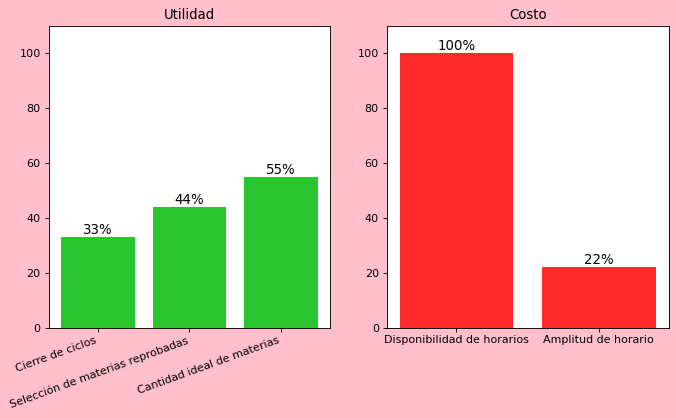

In [210]:
fig, axs = plt.subplots(1,2, dpi= 80, figsize=(10,5), sharey= False,facecolor = 'pink')
axs[0].set_ylim([0,110])
axs[1].set_ylim([0,110])

axs[0].set_facecolor('white')
axs[0].set_facecolor('white')

axs[0].set_xticklabels(x,rotation=20, ha = 'right')
axs[0].bar(x, y,facecolor = '#28C52E')
axs[0].bar_label((axs[0].containers[0]), fontsize = 12,labels=convertirListaIntToListaString(array=y), label_type='edge')
axs[0].set_title('Utilidad')

axs[1].bar(x2,y2,facecolor = '#FF2929')
axs[1].bar_label((axs[1].containers[0]), fontsize = 12,labels=convertirListaIntToListaString(array=y2), label_type='edge')
axs[1].set_title('Costo')

#axs[0].set_xticklabels(x,rotation=45, ha = 'right')

C:\Users\eddie\AppData\Local\Temp\ipykernel_12580\1112909379.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(x,rotation = 15, ha = 'right')
C:\Users\eddie\AppData\Local\Temp\ipykernel_12580\1112909379.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(x2,rotation = 15, ha = 'right')


[Text(0, 0, 'Disponibilidad de horarios'), Text(1, 0, 'Amplitud de horario')]

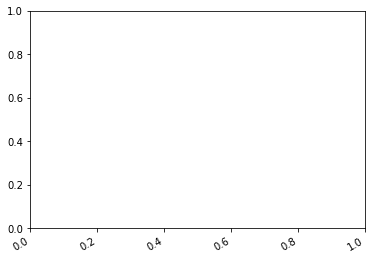

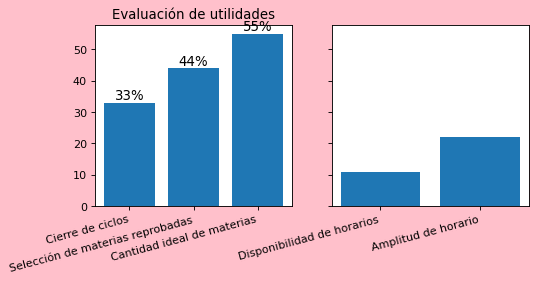

In [152]:

plt.xticks(rotation = 30, ha = 'right')
fig, axs = plt.subplots(1,2, dpi= 80, figsize=(7,3), sharey= True, facecolor='pink')

axs[0].bar(x,y)
axs[0].set_xticklabels(x,rotation = 15, ha = 'right')
axs[0].bar_label((axs[0].containers[0]), fontsize = 12,labels=convertirListaIntToListaString(array=y), label_type='edge')
axs[0].set_title('Evaluación de utilidades')

axs[1].bar(x2,y2)
axs[1].set_xticklabels(x2,rotation = 15, ha = 'right')

In [151]:
def convertirListaIntToListaString(array):
    listaString = []
    for element in array:
        aux = str(element) + "%"
        listaString.append(aux)
    return listaString


In [215]:
carga = obtenerDatosCarga(toolbox.population(n = 1)[0])

In [227]:
a = list(carga['clave'].values)

In [234]:
a = list(plan['preespecialidad'].unique())

In [244]:
str(a[1])

'Inteligencia Organizacional y de negocios'

In [258]:
elib = plan.query('tipo == "Elección libre"')

In [265]:
elib = plan.query('tipo == "Elección libre" or (tipo == "Preespecialidad" and preespecialidad != "' + a[1] + '")')

In [270]:
set(elib['clave'])

{'ID0160',
 'ID0161',
 'ID0262',
 'ID0263',
 'ID0264',
 'ID0265',
 'ID3415',
 'ID3416',
 'ID3417',
 'ID3418',
 'ID3419',
 'ID3466',
 'ID3467',
 'ID3468',
 'ID3469',
 'ID3470',
 'ID3471',
 'ID3472',
 'ID3473',
 'ID3474',
 'II0422',
 'II0423',
 'IL0102',
 'IL0414',
 'IL3422',
 'IT0103',
 'IT0317',
 'IT3472',
 'NI0423',
 'NI3431'}

In [281]:
obtenerDatosCarga([4])

,clave,ciclos,Nombre,Maestro,Lunes,Martes,Miercoles,Jueves,Viernes,tipo
4,ID0205,2,Geometría computacional,Naredo García / Enrique,-,-,-,09:00-11:00,10:00-11:00,Basica
